# Recurrent Neural Networks (RNNs)

Recurrent Neural Networks (RNNs) are a class of neural networks that are used for sequence prediction problems

* RNNs are capable of learning sequential dependencies within sequence data

We most often deal in temporal sequences (sequences ordered in terms of time) so we say:

* RNNs learn temporal dependencies within a time-series data

For example: an RNN could be trained to forecast rain. If presented with a time-series dataset of hourly humidity levels as features and hourly rainfall as the target, a well trained RNN would learn temporal dependencies between humidity and use this to predict the likelihood of rainfall one, two, ..., n units of time in the future. It might discover a temporal pattern that after three consecutive days of rising relative humidity levels we often expect rain over the next two days.

Although often less effective, is possible to use architectures such as MLPs and CNNs to learn temporal dependencies. We will now show how we formalize temporal data for a forecasting problem.


### Univariate Temporal Data

We have a single time series $\tilde{X}$ with historical values:
$$\tilde{X} = [x_1, x_2, x_3, ..., x_{T-1}, x_T]$$

We apply time series embedding to the historical values to generate features $X$ and targets $y$ representing one training/testing sample for machine learning model:
$$ X_t = [x_{t-n+1}, ..., x_{t-1}, x_t] $$
$$ y_t = [x_{t+1}, ..., x_{t+m-1}] $$

This is saying: we train a model to use the $n$ previous values in the sequence to predict the next $m$ values. We refer to $n$ as our "window size" or "lookback period" and $m$ is our "prediction horizon".

Time series embedding is implemented as a sliding window to maximize the number of training/testing samples available to us. For example with window size 2, window stride 1, prediction horizon 1 two consecutives samples would look like: $X_2 = [x_1, x_2]$, $y_2 = x_3$ and $X_3 = [x_2, x_3]$, $y_3 = x_4$.

### Temporal Dependencies Using CNNs
For sequence prediction tasks such as time series forecasting, CNNs can capture local dependencies but often struggle to model long-term relationships within the data, as their filters have a fixed size, which limits their receptive field.

### Vanilla RNN

Given a sequence of input $[x_{t-n+1}, ..., x_{t-1}, x_t]$, an RNN process one input value at a time $x_i$. For each of these time-steps $i$, it will update an internal 'hidden state' (or memory state) from $h_{i-1}$ to $h_i$ and it will produce an output $o_{i}$. The interal hidden state is NOT a learnable model weight, rather, it is used to retain temporal information about the sequence. For training the model $o_i$ is of use to us, but when we're testing the model we only care about the final output as this represent our final prediction $\hat{y}=\hat{x}_{t+1}=o_{t}$.

<p style="text-align:center;">Vanilla RNN Architecture</p>
<img src="vanilla_rnn.png" width="750" align="center">


#### Vanilla RNN: Forward Propagation Through Time

$$h_i = \sigma(W \cdot h_{i-1} + U \cdot x_{i-1})$$

$$o_i = \sigma(V \cdot h_i)$$

Where $\sigma$ is some activation function and $U$, $W$, $V$ are the learnable weights.

#### Vanilla RNN: Back Propagation Through Time

When a single training sample $[x_{t-n+1}, ..., x_{t-1}, x_t]$ has undergone forward propagation through time we end up with a number of outputs generated at each time step $[o_{t-n+1}, ..., o_{t-1}, o_t]$. 

The total loss over all time steps can be expressed as:
$$Loss = \sum_{i=t-n+1}^{t} Loss_i(o_i, x_i)$$

Therefore, the weight gradients will be a sum of the partial derivatives at each time step:

$$\frac{\partial L}{\partial V} = \sum_{i=t-n+1}^{t} \frac{\partial L_i}{\partial o_i} \cdot \frac{\partial o_i}{\partial V}$$

$$\frac{\partial L}{\partial W} = \sum_{i=t-n+1}^{t} \frac{\partial L_i}{\partial h_i} \cdot \frac{\partial h_i}{\partial W}$$

$$\frac{\partial L}{\partial U} = \sum_{i=t-n+1}^{t} \frac{\partial L_i}{\partial h_i} \cdot \frac{\partial h_i}{\partial U}$$

Leading to the following weight updates:

$$V = V - \eta \frac{\partial L}{\partial V}$$ 
$$W = W - \eta \frac{\partial L}{\partial W}$$ 
$$U = U - \eta \frac{\partial L}{\partial U}$$ 

#### Vanilla RNN Vanishing Gradients Problem

Vanilla RNNs suffer from the vanishing gradient problem, where gradients of the loss function become exponentially smaller as they are propagated backward through each timestep in the training data. This makes it difficult for RNNs to learn long-range dependencies within the data since older samples in the time window will have a much smaller effect on weight updates. 

### LSTMs and GRUs

Long Short-Term Memory (LSTM) and Gated Recurrent Networks (GRUs) are an extension of RNNs designed to avoid the vanishing gradient problem. They include mechanisms called gates that regulate the flow of information. These gates (input, forget, and output gates for LSTM and reset, and update gates for GRUs) allow the network to selectively remember or forget things, which helps in maintaining stable gradients and learning long-term dependencies.

### General Disadvantages of RNNs
RNNs, including LSTMs, are computationally intensive and difficult to parallelize due to their sequential nature. They also can struggle with very long sequences and sometimes require sophisticated techniques to stabilize training.

### Need for Attention Mechanisms
The attention mechanism provides a means of weighting the significance of different inputs differently, allowing the model to focus on the most relevant parts of the input sequence for making predictions. This is particularly useful for tasks where only certain parts of the sequence are informative for the output. Attention mechanisms can dramatically improve the performance of sequence models and have led to significant advancements, such as in natural language processing with the development of Transformers neural networks.


<img src="sequence_processing_family.png" width="1000" align="center">

### RNN Example

In this example we implement a vanilla RNN, LSTM and 1D-CNN to predict the daily temperature one day in advanced (prediction horizon of 1) usig the univariate time series in daily-min-temperatures.csv

(See the next code example on Seq2Seq for annotations on RNN and LSTM PyTorch models)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Check device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load data:
data = np.loadtxt('daily-min-temperatures.csv', delimiter=',', skiprows=1, usecols=1)

# Normalize data:
max_val = np.max(data)
min_val = np.min(data)
data_normalized = (data - min_val) / (max_val - min_val)

# Convert data to PyTorch tensors:
data_normalized = torch.FloatTensor(data_normalized).view(-1)

# Creates windows
def time_series_embedding(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

seq_length = 10 #
data_time_embed = time_series_embedding(data_normalized, seq_length)

# Split data into train and test sets
data_time_embed = [data_time_embed[i] for i in torch.randperm(len(data_time_embed))]
split_ratio = 0.8
split_index = int(len(data_time_embed) * split_ratio)
train_set = data_time_embed[:split_index]
test_set = data_time_embed[split_index:]

batch_size = 20
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [10]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = torch.zeros(1,1,self.hidden_layer_size).to(device)

    def forward(self, input_seq):
        rnn_out, self.hidden_cell = self.rnn(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        #print(f"rnn_out.shape: {rnn_out.shape}")
        predictions = self.linear(rnn_out.view(len(input_seq), -1))
        #print(f"rnn predictions.shape: {predictions.shape}")
        return predictions

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).to(device),
                            torch.zeros(1,1,self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        #print(f"input_seq.shape: {input_seq.shape}")
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        #print(f"lstm_out.shape: {lstm_out.shape}")
        #print(f"self.hidden_cell.shape: {self.hidden_cell.shape}")
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        #print(f"lstm predictions.shape: {predictions.shape}")
        return predictions

class CNNModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, hidden_layer_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_layer_size, hidden_layer_size, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(hidden_layer_size * input_size, output_size)

    def forward(self, x):
        x = x.view(x.shape[0], 1, -1)  # Reshape to (batch, channels, seq_length)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x

In [17]:
def train_model(model, train_loader, num_epochs=50):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(num_epochs):
        for seq, labels in train_loader:
            optimizer.zero_grad()
            if isinstance(model, LSTMModel):
                model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                                 torch.zeros(1, 1, model.hidden_layer_size).to(device))
            elif isinstance(model, RNNModel):
                model.hidden_cell = torch.zeros(1, 1, model.hidden_layer_size).to(device)
            
            seq, labels = seq.to(device), labels.to(device)
            y_pred = model(seq)
            #print(f"labels.shape: {labels.shape}")
            #print(f"y_pred.shape: {y_pred.shape}")
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
        if epoch%5 == 0:
            print(f'Epoch {epoch} Loss: {single_loss.item()}')

    print(f'Final Loss: {single_loss.item()}')

def validate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for seq, labels in test_loader:
            seq, labels = seq.to(device), labels.to(device)
            y_pred = model(seq)
            #print(f"y_pred.shape: {y_pred.shape}")
            #print(f"labels.shape: {labels.shape}")
            predictions.append(y_pred.cpu().numpy().flatten())
            actuals.append(labels.cpu().numpy().flatten())
    return predictions, actuals

def plot_results(actual, predicted, xlims=None):
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111)
    if xlims:
        x_mesh = np.linspace(xlims[0],xlims[1], xlims[1]-xlims[0])
    else:
        x_mesh = np.linspace(0, actual.shape[0], actual.shape[0])
    
    ax.plot(x_mesh, actual[xlims[0]:xlims[1]], label='Actual Data')
    for k in predicted.keys():
        ax.plot(x_mesh, predicted[k][xlims[0]:xlims[1]], label=f'Predicted {k} Data')
        
    ax.set_title('Time Series Prediction')
    ax.legend()
    plt.show()

In [18]:
print("Training LSTM")
lstm_model = LSTMModel(input_size=seq_length, hidden_layer_size=50, output_size=1).to(device)
train_model(lstm_model, train_loader, num_epochs=2)
print("Training RNN")
rnn_model = RNNModel(input_size=seq_length, hidden_layer_size=50, output_size=1).to(device)
train_model(rnn_model, train_loader, num_epochs=2)
print("Training CNN")
cnn_model = CNNModel(input_size=seq_length, hidden_layer_size=50, output_size=1).to(device)
train_model(cnn_model, train_loader, num_epochs=2)

Training LSTM
Epoch 0 Loss: 0.01338156871497631
Final Loss: 0.02151130884885788
Training RNN
Epoch 0 Loss: 0.010106607340276241
Final Loss: 0.007616723887622356
Training CNN
Epoch 0 Loss: 0.006787105463445187
Final Loss: 0.012033889070153236


In [19]:
# Assuming test_loader is defined similarly to train_loader but with test data
predictions = {}

preds, acts = validate_model(lstm_model, test_loader)
preds = np.concatenate(preds, axis=0)
acts = np.concatenate(acts, axis=0)
predictions['LSTM'] = preds
actuals = acts

preds, acts = validate_model(rnn_model, test_loader)
preds = np.concatenate(preds, axis=0)
predictions['RNN'] = preds

preds, acts = validate_model(cnn_model, test_loader)
preds = np.concatenate(preds, axis=0)
predictions['CNN'] = preds

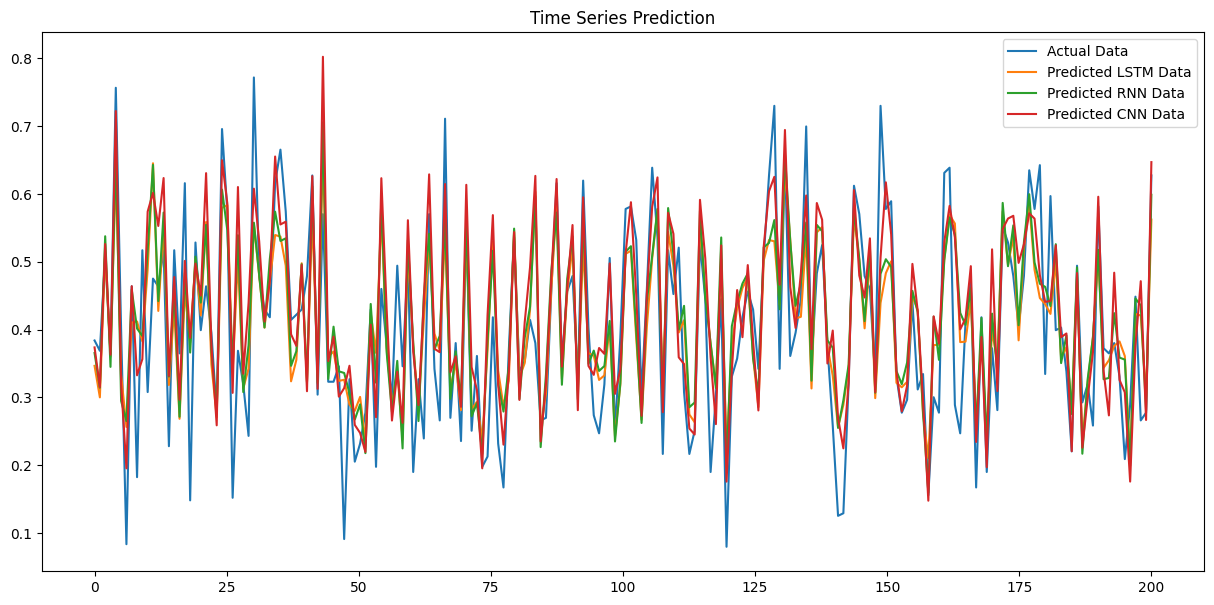

In [20]:
#plot_results(actuals, predictions)
plot_results(actuals, predictions,xlims=(0,200))

# Large Language Models (LLMs)

LLMs are artificial intelligence systems designed to process and/or generate human-like text. Some LLMs can be designed to receive numerical data and generate text, receive text and generate numerical data, receive text and generate text.

### LLMs Preprocressing

<b>Tokenization</b> is the process of breaking down text into smaller units, called tokens. Tokens can be words, subwords, or even characters. 

In [8]:
from torchtext.data.utils import get_tokenizer

demo_tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

sentence = "hello world, hello Australia, how ya going Sydney?"
tokenized_stence = demo_tokenizer(sentence)

print(f"Tokenized sentence: {tokenized_stence}")

Tokenized sentence: ['hello', 'world', ',', 'hello', 'Australia', ',', 'how', 'ya', 'going', 'Sydney', '?']


<b>Token Encoding</b> involves converting tokens into numerical data that a deep learning model can process. Since models do not understand text but operate on numbers, encoding transforms each token into a unique integer. The set of all unique tokens is referred to as a vocabulary. 

In [9]:
from torchtext.vocab import build_vocab_from_iterator

# Define a function to yield tokenized sentences
def demo_yield_tokens(data_iter, tokenizer):
    for sentence in data_iter:
        yield tokenizer(sentence)

demo_vocab = build_vocab_from_iterator(demo_yield_tokens([sentence], demo_tokenizer), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
#
encoded_sentence = [demo_vocab[token] for token in tokenized_stence]
print(f"Encoded Sentence: {encoded_sentence}\n")
print("Vocabulary encodings:")
print(demo_vocab.get_stoi())

Encoded Sentence: [5, 11, 4, 5, 7, 4, 10, 12, 9, 8, 6]

Vocabulary encodings:
{'Australia': 7, '<bos>': 2, '<unk>': 0, '?': 6, '<eos>': 3, '<pad>': 1, ',': 4, 'hello': 5, 'Sydney': 8, 'how': 10, 'going': 9, 'world': 11, 'ya': 12}


The 'specials' argument in build_vocab_from_iterator is used to specify special tokens that are often inserted into sequences of text:
* \<unk\>  (Unknown Token): This token represents words that are not present in the vocabulary. When tokenizing text, if a word is encountered that is not in the vocabulary, it will be replaced by this <unk> token.
* \<pad\> (Padding Token): This token is used to pad sequences to the same length during batching, especially when working with variable-length sequences in neural networks. It ensures that all sequences in a batch have the same length.
* \<bos\> (Beginning of Sentence Token): This token marks the beginning of a sentence. It can be used in various natural language processing tasks where knowing the start of a sentence is important, such as language generation tasks.
* \<eos\> (End of Sentence Token): This token marks the end of a sentence. Similar to <bos>, it can be useful in language generation tasks to indicate the end of a generated sentence.

<b>Embeddings</b> are dense vector representations of encoded tokens where similar tokens have similar embedding vectors. They are typically generated by embedding layers in neural network models. These layers often utilize architectures like simple lookup tables where each token index is mapped to a high-dimensional vector, or they can be more complex, involving trainable parameters. 

<p style="text-align:center;">'Computer' closest words in a word embedding space (generated using: http://vectors.nlpl.eu/explore/embeddings/en/#)</p>
<img src="word_embedding_space.png" width="400" align="center">

<p style="text-align:center;">Embedding space for words in the sentence: "The thirsty fox goes to the river bank, and the wealthy investor check their savings bank." (generated using: https://remykarem.github.io/word2vec-demo/)</p>
<img src="sentence_embedding.png" width="400" align="center">

More advanced embedding models like BERT (Bidirectional Encoder Representations from Transformers), ELMo (Embeddings from Language Models), and GPT (Generative Pre-trained Transformer) generate embeddings that are context-sensitive. This involves encoding positional information of each word in the sentence directly into the embeddings. Words would be context-dependent, meaning the word "bank" in the phrase "river bank" would have a different embedding than in "savings bank".

Embedding layers often consist of a deep learning architecture called an Encoder-Decoder network, so we often refer to the embedding layer responsible for producing word embedding from encoded tokens as 'the encoder'. Not to be confused with the 'token encoder' which simply maps token strings to integers.

## Sequence-to-Sequence (Seq2Seq) 

Seq2Seq models are a specific type of LLM model architecture designed for converting sequences from one domain (e.g., sentences in English) to sequences in another domain (e.g., sentences in German). These models typically use a combination of two main components: a recurrent encoder and a recurrent decoder.

<p style="text-align:center;">Seq2Seq Architecture</p>
<img src="seq2seq_arc.png" width="600" align="center">

##### Seq2Seq Encoder

The recurrent encoder processes the input sequence one timestep (word) at a time. At each timestep, it updates its hidden state based on the current input and the previous hidden state and produces an output. 

##### Seq2Seq Decoder

After the recurrent decoder proccesses an \<bos\> it uses the encoder's final hidden state (called the 'context vector') and sets this to be its own initial hidden state. The encoder's final hidden state is thought to encapsulate all the necessary information from the input sequence to start the output generation process. It serves as the initial context or the "summary" of the input sequence. 

<p style="text-align:center;">Seq2Seq Translator</p>
<img src="seq2seq_translator1.gif" width="600" align="center">

For each subsequent step, the decoder updates its internal state based on the previously generated word and the previous internal state, then generates the next word. This process continues until a we either produce a termination token (like \<eos\>), signifying the end of the output sequence, or until we reach a pre-defined limit on the output size.

<img src="seq2seq_translator2.gif" width="600" align="center">


### Seq2Seq Example: Translating Text

The following code implements, trains and tests a Seq2Seq model designed to translate sentences from English to German. Effectively training such a model requires alot of time and computational power, so the model doesn't perform well at all. But this provides a useful demonstration for implementing LLMs in PyTorch. 

The model outputs one-hot encoded representations of each word in the sentence. This allows us to use cross entropy loss, a simple classification loss function. This means that given a sequence of English words \[\<bos\>, e1, e2, e3, \<eos\>\] our model might translate this to a sequence of German words \[\<bos\>, g1, g2, g3, g4, \<eos\>\]. To compute the loss we padd the English sequence \[\<bos\>, e1, e2, e3, <pad>\, \<eos\>\] and compute the difference between corresponding words in the sequence.

This is not a very effective way to train a model to translate text. In future lessons we will cover more advanced loss functions, such as Connectionist Temporal Classification (CTC), which allow us to handle differences in sequence lengths an word arrangement without explicit alignment between input and output sequences.

<p style="text-align:center;">One-hot encoding representation of a very small vocabulary</p>
<img src="one_hot_encode_vocab.png" width="300" align="center">


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import Multi30k
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torchtext.transforms as T
from collections import Counter
import random

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Tokenizers
# Tokenizers for English and German languages using spaCy
tokenizer_en = get_tokenizer("spacy", language="en_core_web_sm")
tokenizer_de = get_tokenizer("spacy", language="de_core_news_sm")

# Load the Multi30k dataset
train_data, _, _ = Multi30k(split=('train', 'valid', 'test'), language_pair=('en', 'de'))
# train_data consists of tuples: (sentence in english, same sentence in german)

# Reduce train_data size
train_data_list = list(train_data)
train_data = train_data_list[:100]

# Define a function to yield tokens from the dataset iterator
# Used to build a torchtext vocabulary object
def yield_tokens(data_iter, tokenizer, language):
    for data in data_iter:
        if language == 'en':
            #print(data[0])
            yield tokenizer(data[0])
        else:
            #print(data[1])
            yield tokenizer(data[1])

# Build vocabularies for English and German
vocab_en = build_vocab_from_iterator(yield_tokens(train_data, tokenizer_en, 'en'), specials=['<unk>', '<pad>', '<bos>', '<eos>'], min_freq=1)
vocab_de = build_vocab_from_iterator(yield_tokens(train_data, tokenizer_de, 'de'), specials=['<unk>', '<pad>', '<bos>', '<eos>'], min_freq=1)
#vocab objects provide a mapping from unique tokens (words) to unique integers and vice versa

# Set special tokens indices for later use
UNK_IDX = vocab_en['<unk>']
PAD_IDX = vocab_en['<pad>']
BOS_IDX = vocab_en['<bos>']
EOS_IDX = vocab_en['<eos>']

print(f"English vocabulary size: {len(vocab_en)}")
print(f"German vocabulary size: {len(vocab_de)}")

# Function to tokenize and transform source and target sentences into tensors
def tokenize_and_transform(src, trg, src_vocab, trg_vocab, tokenizer_src, tokenizer_trg):
    src_encoded = [src_vocab['<bos>']] + [src_vocab[token] for token in tokenizer_src(src)] + [src_vocab['<eos>']]
    trg_encoded = [trg_vocab['<bos>']] + [trg_vocab[token] for token in tokenizer_trg(trg)] + [trg_vocab['<eos>']]
    return torch.tensor(src_encoded, dtype=torch.long), torch.tensor(trg_encoded, dtype=torch.long)


'''
collate_fn functions can be implemented for a DataLoader to specify how we want to collate (process and combine)
individual samples into batches. It takes a list of samples, where each sample is a tuple containing the data 
from one example in the dataset, and should return a batch of data suitable for processing by the model.
'''
# In our context, the collate_fn tokenizes and encodes each source and target sentence
# and pad sequences in a batch since our encoder wants sequences of uniform length
def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_tensor, trg_tensor = tokenize_and_transform(src_sample, trg_sample, vocab_en, vocab_de, tokenizer_en, tokenizer_de)
        src_batch.append(src_tensor)
        trg_batch.append(trg_tensor)
    src_batch = pad_sequence(src_batch, padding_value=vocab_en['<pad>'])
    trg_batch = pad_sequence(trg_batch, padding_value=vocab_de['<pad>'])
    return src_batch, trg_batch

# Create DataLoader
batch_size = 200
train_iterator = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

print("English Vocab")
print(vocab_en.get_itos())

print("\n\nGerman Vocab")
print(vocab_de.get_itos())

English vocabulary size: 458
German vocabulary size: 474
English Vocab
['<unk>', '<pad>', '<bos>', '<eos>', 'a', '.', 'A', 'in', 'the', 'man', 'on', 'is', 'and', 'of', 'with', 'are', 'at', 'black', 'dog', ',', 'green', 'his', 'white', 'Two', 'red', 'boy', 'men', 'standing', 'to', 'front', 'people', 'shirt', 'sitting', 'street', 'by', 'walking', 'young', 'large', 'little', 'outside', 'toy', 'water', 'while', 'yellow', 'The', 'blue', 'down', 'for', 'girl', 'into', 'jacket', 'person', 'small', 'snow', 'their', 'wearing', 'woman', 'women', 'Five', 'an', 'around', 'bench', 'car', 'crowd', 'dressed', 'grass', 'hat', 'looking', 'road', 'three', 'through', 'top', 'two', 'working', "'s", 'Man', 'Several', 'Three', 'also', 'another', 'as', 'baby', 'back', 'background', 'beach', 'bicycle', 'cake', 'children', 'city', 'climbing', 'couple', 'cup', 'elderly', 'face', 'glasses', 'group', 'hand', 'hard', 'hats', 'having', 'her', 'holding', 'holds', 'ice', 'jumping', 'jumps', 'kicking', 'lab', 'like', 

In [11]:
# Model Definition
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        #nn.Embedding is a simple trainable lookup table produces word embeddings from token encodings.
        ### input_dim: vocabulary size, it must know how many words are in the vocabulary
        ### emb_dim: size of each embedding vector (hyper-parameter)
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        #nn.LSTM
        ### emb_dim: input size - number of expected features for the LSTM
        ### hid_dim: number of features in the hidden state (hyper-parameter)
        ### PyTorch specifies that the output of the LSTM will also have the same dimension
        ###  as the hidden state (hid_dim).
        self.rnn = nn.LSTM(emb_dim, hid_dim)

    def forward(self, src):
        # src shape is (src length, batch size)
        ## (remember src length has been padded per-batch by collate_fn)
        embedded = self.embedding(src)
        # embedded shape is (src length, batch size, embedding dim)
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs shape is (src length, batch size, hidden dim)
        # this encoder LSTM executes one timestep for each word (src length)
        # the returned outputs, (hidden, cell) are always from the final hidden layer
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        #output_dim is the size of the target vocab
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim)
        
        #Final linear layer used to project the LSTM output to a one-hot encoding vector over the vocabulary
        self.fc_out = nn.Linear(hid_dim, output_dim)

    def forward(self, input_seq, hidden, cell):
        #input_seq should only be one word, so it has shape (1, batch_size)
        ## for the first call to forward(), the input should be <bos>
        ## for subsequent calls to forward(), the input should be the word predicted from the previous decoder timestep
        
        ## for the first call to forward, hidden and cell are the states from the final encoder timestep
        ## for subsequent calls to forward, hidden and cell are the states from the previous decoder timestep
        
        input_seq = input_seq.unsqueeze(0)
        embedded = self.embedding(input_seq)
        
        #embedded only has one word, so this rnn will only process one time step and predict the next word
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #we want our prediction to be a one-hot encoding of the predicted word
        # so we pass the output (which has same dimension as the hidden state)
        # through a fully connected layer with output_dim = len(target vocab)
        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        #trg:
        ## when this forward() function is called by the training loop we provide it the target sequence of words
        ## when called by a testing function like translate_sentence, we only provide it with either <bos> or the previous predicted word
        
        trg_len = trg.shape[0] #number of words
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(src)
        
        input_seq = trg[0, :]  # first input to the decoder is the <bos> token
        
        
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input_seq, hidden, cell)
            #output is a one-hot encoding of the predicted word
            #so its dimension is the size of the target vocab
            
            outputs[t] = output
            
            #choose the index of the one-hot encoding with the largest value
            top1 = output.argmax(1)
            #this index represent the token encoding of the predicted word
            #we apply something called teacher forcing here too
            ## (https://en.wikipedia.org/wiki/Teacher_forcing)
            input_seq = trg[t] if random.random() < teacher_forcing_ratio else top1
        
        return outputs

In [12]:
# Model, Optimizer, and Loss
INPUT_DIM = len(vocab_en)
OUTPUT_DIM = len(vocab_de)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM)

model = Seq2Seq(enc, dec, device).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [13]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src, trg = batch
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()
        output = model(src, trg) 
        
        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)  # Flatten the output for loss calculation, skipping <bos> token
        trg = trg[1:].reshape(-1)  # Flatten target tensor, skipping <bos> token

        loss = criterion(output, trg)  # Calculate loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  # Clip gradients to avoid exploding gradients
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

num_epochs = 1
for ep in range(num_epochs):
    results = train(model, train_iterator, optimizer, criterion, 2)
    print(f"Epoch: {ep}")
    print(f"Avg Cross-entropy loss: {results}")

Epoch: 0
6.156847953796387


In [15]:
def translate_sentence(sentence, src_tokenizer, src_vocab, trg_tokenizer, trg_vocab, model, device, max_len=50):
    model.eval()
        
    src_tokens = src_tokenizer(sentence)
    src_encoded = [src_vocab['<bos>']] + [src_vocab[tok] for tok in src_tokens] + [src_vocab['<eos>']] 
    src_tensor = torch.LongTensor(src_encoded).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_tensor)])

    trg_encoded = [trg_vocab['<bos>']]

    #pass the source sentence into the encoder
    # and get the final hidden state from the encoder 
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)
    
    #never generate more than max_len words
    for i in range(max_len):
        
        #passes <bos> to the encoder on the first iteration, then passes previous predicted word
        trg_tensor = torch.LongTensor([trg_encoded[-1]]).to(device)
        
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
        
        pred_token = output.argmax(1).item()
        trg_encoded.append(pred_token)

        if pred_token == trg_vocab['<eos>']: #if predicted <eos> then we are finished translating
            break
    print(f"encoded predicted sentence: {trg_encoded}")
    trg_tokens = [trg_vocab.get_itos()[i] for i in trg_encoded]
    
    return trg_tokens[1:]  # skip <sos> token

sentence = "Justin is painting the sky"
translated = translate_sentence(sentence, tokenizer_en, vocab_en, tokenizer_de, vocab_de, model, device, max_len=50)
print("Translated sentence:")
print(translated)

encoded predicted sentence: [2, 5, 37, 381, 140, 451, 393, 227, 220, 160, 441, 410, 140, 199, 195, 388, 25, 25, 339, 214, 214, 31, 31, 405, 4, 3]
Translated sentence:
['Ein', 'während', 'ihnen', 'Bier', 'tanzen', 'kämpfen', 'Mantel', 'Kunstwerke', 'Fahnen', 'seltsamen', 'neue', 'Bier', 'Instrumenten', 'Hundespielzeug', 'kehrt', 'Männer', 'Männer', 'darunterliegende', 'Kletterer', 'Kletterer', 'Frau', 'Frau', 'männlicher', '.', '<eos>']


### Disadvantages of RNN-based LLMs

The primary issue with RNNs is their sequential nature, which requires data to be processed in a strict order. This limits the parallelization capabilities of the models, making training on very large datasets time-consuming and computationally expensive. Moreover, despite improvements like LSTM and GRU architectures, RNNs can still struggle with learning dependencies across long sequences, a critical factor in many natural language processing tasks.

RNN-based LLMs:
* very slow to train and perform inference
* hidden states struggle to learn long time-dependencies

In future lessons we will learn about Transformer networks, which address these short commings. 